# Homework 4 - 2305

*   Tommaso Bertola 2086990
*    Giacomo Di Prima 2086992
*    Giuseppe Viterbo 2086516
*    Marzo Zenari 2097012



In [1]:
# XGBoost 
import numpy as np
import matplotlib.pyplot as plt

#XGB
import xgboost
from xgboost import XGBRegressor
from xgboost import XGBClassifier
import graphviz
from xgboost import plot_importance, to_graphviz, plot_tree
print("XGBoost version:",xgboost.__version__)

#NN
import tensorflow as tf
import keras, sklearn
from keras.models import Sequential
from keras.layers import Dense, Dropout
import tensorflow.random as tf_r

tf_r.set_seed(123)
plt.rcParams['font.size'] = 15

XGBoost version: 1.7.5


## Generation of the data and plot

In [2]:
def gen_data(CASE, N, perc_train, S=2):
    np.random.seed(123)
    N_train = int(N*perc_train)
    N_test  = N - N_train
    x = S*(2*np.random.rand(N,2)-1)
    y = np.zeros(N) # float
    for n in range(N):
        if CASE==0:
            if x[n,1]<-0.6 and x[n,0]>-0.2: y[n]=1
            if x[n,1]>0.4 and x[n,0]<-0.8: y[n]=1
            if x[n,1]>1.0 and x[n,0]>0.8: y[n]=1
        elif CASE==1:
            if x[n,1]<0 and x[n,0]>0.5: y[n]=1
            if x[n,1]>0 and np.sqrt((x[n,0]+0.3)**2+x[n,1]**2)<1.5: y[n]=1
                
    x_train,y_train = x[:N_train],y[:N_train]
    x_test,y_test = x[N_train:],y[N_train:]
    print('N:', N, 'N_train:', N_train, 'CASE:', CASE)
    return x_train, y_train, x_test, y_test

def plot_scatter(x, y, c_map='plasma', s=4):
    plt.scatter(x[:,0], x[:,1], c=y, cmap=c_map, s=s)

N: 10000 N_train: 8000 CASE: 1


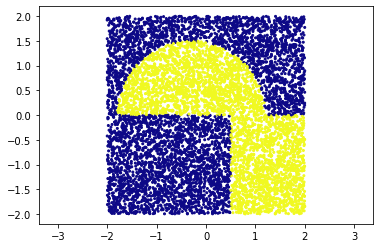

In [3]:
CASE=1
S=2
N=10000
perc_train=0.80
x_train, y_train, x_test, y_test = gen_data(CASE=CASE, N=N, perc_train=perc_train, S=S)

plt.figure(figsize=(6,4))
plot_scatter(x_train, y_train)
if CASE == 2 or CASE == 3: plt.colorbar()
plt.axis('equal')
plt.show()

# 1) XGB vs NN

## Classifier: XGB

In [4]:
def classify(clf=XGBClassifier(),show=False):
    clf.fit(x_train,y_train)
    
    error_xgb=100*(1-clf.score(x_test, y_test))
    if show:
        print("errors: {:.2f}%".format(error_xgb))
        
    dx = 0.02
    x_seq=np.arange(-S,S+dx,dx)
    nx = len(x_seq)
    x_plot=np.zeros((nx*nx,2))
    q=0
    for i in range(nx):
        for j in range(nx):
            x_plot[q,:] = [x_seq[i],x_seq[j]]
            q+=1
    y_plot= clf.predict(x_plot)
    
    if show:    
        plt.figure(figsize=(6,6))
        plt.title(str(clf))

        plot_scatter(x_plot,y_plot)
       # plot_scatter(x_train,y_train,s=7)
        plt.show()
    
        dump_list = clf.get_booster().get_dump()
        num_trees = len(dump_list)
        print("num_trees=",num_trees)
        
        fig, AX = plt.subplots(3,1,figsize=(30, 30))
        for i in range(min(3,num_trees)):
            ax=AX[i]
            plot_tree(clf, num_trees=i, ax=ax)
        fig.savefig("DATA/tree-classif.png", dpi=300, pad_inches=0.02)   
        plt.show()
    return x_plot, y_plot, error_xgb

### simple case

errors: 0.80%


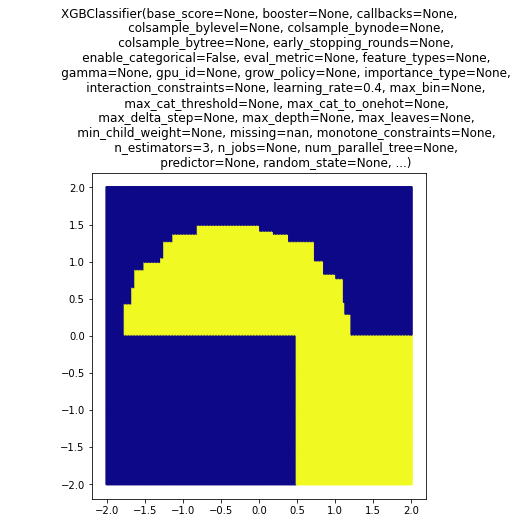

num_trees= 3


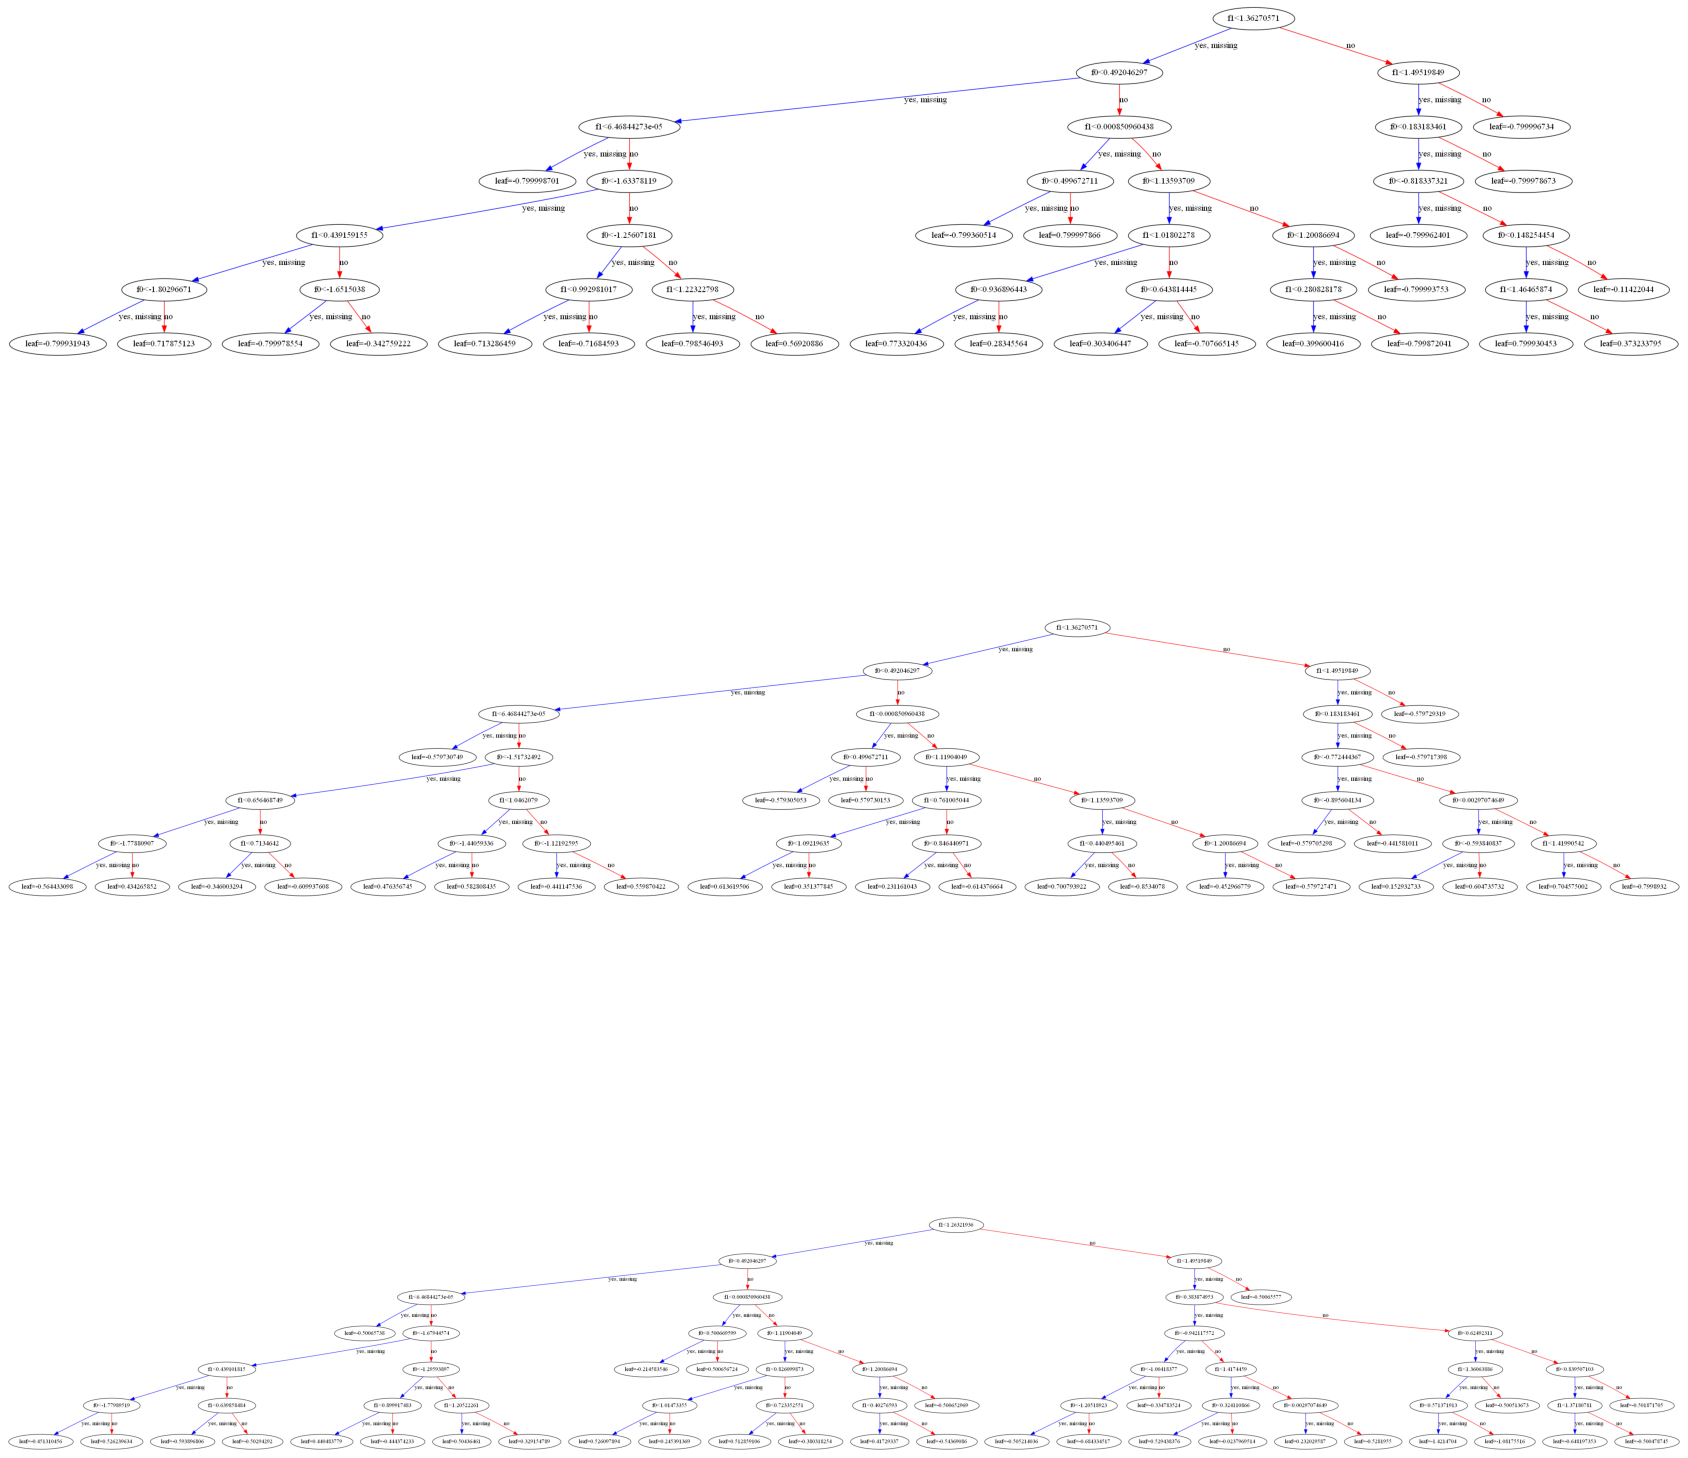

In [5]:
xg_x_plot, xg_y_plot, _=classify(XGBClassifier(seed=1,
                                               objective='binary:logistic',
                                               learning_rate=0.4,
                                               reg_lambda=0.001, n_estimators=3),
                                 show=True)

## Classifier: NN

Rescaling to improve NN

In [6]:
def Rescale(x, S=S):
    return x/S
x_train = Rescale(x_train, S)
#y_train = Rescale(y_train, S)
x_test = Rescale(x_test, S)
#y_test = Rescale(y_test, S)

In [7]:
L=len(x_train[0])

### NN

In [8]:
def create_DNN(act_func, neurons): 
    model = Sequential() #empty template of the neural network
    model.add(Dense(L,input_shape=(L,),activation=act_func)) #add a layer dense (all connection) with a ReLu 2 neuron for 2 x_i
    model.add(Dense(units=neurons,activation=act_func))
    model.add(Dense(units=neurons,activation=act_func))
    model.add(Dense(units=neurons,activation=act_func))
    model.add(Dense(units=neurons,activation=act_func))
    #model.add(Dropout(0.01)) #it is applied to the last layer, need to be reader in keras documentation 
    model.add(Dense(1,activation='sigmoid'))
        
    return model 

In [9]:
def compile_model(optimizer='adam', act_func='ReLu', neurons=30):
    model = create_DNN(act_func, neurons)
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])    
    return model

In [10]:
nepochs=70

model = compile_model(optimizer='RMSprop',
                      act_func='tanh',
                      neurons=10)

history = model.fit(x_train, y_train,
                    epochs = nepochs,
                    batch_size = 100,
                    validation_data=(x_test,y_test),
                    verbose=1)

Epoch 1/70
80/80 [==============================] - 2s 7ms/step - loss: 0.6496 - accuracy: 0.5700 - val_loss: 0.6265 - val_accuracy: 0.6405
Epoch 2/70
80/80 [==============================] - 0s 4ms/step - loss: 0.6120 - accuracy: 0.6653 - val_loss: 0.5942 - val_accuracy: 0.6635
Epoch 3/70
80/80 [==============================] - 0s 3ms/step - loss: 0.5787 - accuracy: 0.6775 - val_loss: 0.5596 - val_accuracy: 0.6650
Epoch 4/70
80/80 [==============================] - 0s 3ms/step - loss: 0.5390 - accuracy: 0.7372 - val_loss: 0.5105 - val_accuracy: 0.7680
Epoch 5/70
80/80 [==============================] - 0s 4ms/step - loss: 0.4922 - accuracy: 0.7696 - val_loss: 0.4667 - val_accuracy: 0.7805
Epoch 6/70
80/80 [==============================] - 0s 3ms/step - loss: 0.4612 - accuracy: 0.7850 - val_loss: 0.4422 - val_accuracy: 0.8190
Epoch 7/70
80/80 [==============================] - 0s 3ms/step - loss: 0.4395 - accuracy: 0.8039 - val_loss: 0.4178 - val_accuracy: 0.8310
Epoch 8/70
80/80 [==

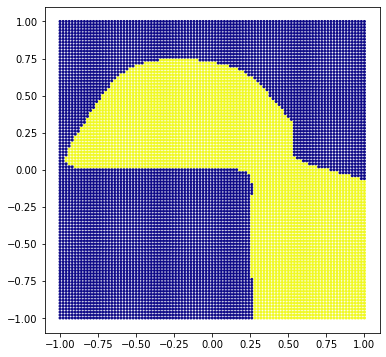

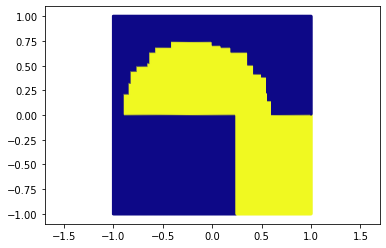

In [11]:
dx = 0.02
x_seq=np.arange(-1,1+dx,dx)
nx = len(x_seq)
x_plot=np.zeros((nx*nx,2))
q=0
for i in range(nx):
    for j in range(nx):
        x_plot[q,:] = [x_seq[i],x_seq[j]]
        q+=1
y_plot= model.predict(x_plot)

y_plot[y_plot>0.5]=1
y_plot[y_plot<0.5]=0
plt.figure(figsize=(6,6))

plot_scatter(x_plot, y_plot)
plt.show()
plot_scatter(xg_x_plot/2,xg_y_plot)
plt.axis("equal")
plt.show()


In [12]:
N=[1e2, 500, 1e3, 1e4]

for n in N:
    x_train, y_train, x_test, y_test = gen_data(CASE=CASE,
                                                N=int(n),
                                                perc_train=perc_train,
                                                S=S)
    xg_x_plot, xg_y_plot, error_xgb =classify(XGBClassifier(seed=1,
                                                objective='binary:logistic',
                                                learning_rate=0.4,
                                                reg_lambda=0.001,
                                                n_estimators=3),
                                  show=False)
    x_train = Rescale(x_train, S)
    x_test = Rescale(x_test, S)
    nepochs=70
    model = compile_model(optimizer='RMSprop',
                          act_func='tanh',
                          neurons=10)
    history = model.fit(x_train, y_train,
                        epochs = nepochs,
                        batch_size = 100,
                        validation_data=(x_test,
                                         y_test),
                        verbose=0)
    print("Acc XGB:", (100-error_xgb)/100 , "%")
    print("Last Acc NN: {:.2f}%".format(history.history['accuracy'][-1]))
    print("***************************")
    


N: 100 N_train: 80 CASE: 1
Acc XGB: 0.7 %
Last Acc NN: 0.70%
***************************
N: 500 N_train: 400 CASE: 1
Acc XGB: 0.96 %
Last Acc NN: 0.84%
***************************
N: 1000 N_train: 800 CASE: 1
Acc XGB: 0.985 %
Last Acc NN: 0.85%
***************************
N: 10000 N_train: 8000 CASE: 1
Acc XGB: 0.992 %
Last Acc NN: 0.98%
***************************


# 2) XGB tuning

In [13]:
def gen_data(CASE, N, perc_train, S=2):
    np.random.seed(123)
    N_train = int(N*perc_train)
    N_test  = N - N_train
    x = S*(2*np.random.rand(N,2)-1)
    y = np.zeros(N) # float
    for n in range(N):
        if CASE==0:
            if x[n,1]<-0.6 and x[n,0]>-0.2: y[n]=1
            if x[n,1]>0.4 and x[n,0]<-0.8: y[n]=1
            if x[n,1]>1.0 and x[n,0]>0.8: y[n]=1
        elif CASE==1:
            if x[n,1]<0 and x[n,0]>0.5: y[n]=1
            if x[n,1]>0 and np.sqrt((x[n,0]+0.3)**2+x[n,1]**2)<1.5: y[n]=1

                
    x_train,y_train = x[:N_train],y[:N_train]
    x_test,y_test = x[N_train:],y[N_train:]
    print('N:', N, 'N_train:', N_train, 'CASE:', CASE)
    return x_train, y_train, x_test, y_test

def plot_scatter(x, y, c_map='plasma', s=4):
    plt.scatter(x[:,0], x[:,1], c=y, cmap=c_map, s=s)

N: 10000 N_train: 8500 CASE: 1


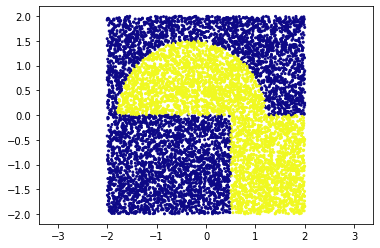

In [14]:
CASE=1
S=2
N=10000
perc_train=0.85
x_train, y_train, x_test, y_test = gen_data(CASE=CASE, N=N, perc_train=perc_train, S=S)
plt.figure(figsize=(6,4))
plot_scatter(x_train, y_train)
if CASE == 2 or CASE == 3: plt.colorbar()
plt.axis('equal')
plt.show()

In [15]:
lam=[100,30,20,10,5,1,0.5,0.1]
for l in lam:
    print("lambda=",l)
    classify(XGBClassifier(seed=1,
                       objective='binary:logistic',
                       learning_rate=0.4,
                       reg_lambda=l, n_estimators=3), show=False)

lambda= 100
lambda= 30
lambda= 20
lambda= 10
lambda= 5
lambda= 1
lambda= 0.5
lambda= 0.1


In [16]:
gam=[0.,1.,2.,4.,10.,20.,40.,100.,200.]
for g in gam:
    print("gamma=",g)
    classify(XGBClassifier(seed=1,
                       objective='binary:logistic',
                       learning_rate=0.4,
                       reg_lambda=1, gamma=g, n_estimators=3), show=False)

gamma= 0.0
gamma= 1.0
gamma= 2.0
gamma= 4.0
gamma= 10.0
gamma= 20.0
gamma= 40.0
gamma= 100.0
gamma= 200.0


In [17]:
n_estimator=[3,4,5,6,7,8]
for n in n_estimator:
    print("n_estimator=",n)
    classify(XGBClassifier(seed=1,
                       objective='binary:logistic',
                       learning_rate=0.4,
                       reg_lambda=1, gamma=1, n_estimators=n), show=False)

n_estimator= 3
n_estimator= 4
n_estimator= 5
n_estimator= 6
n_estimator= 7
n_estimator= 8
